# COVID-19 OPEN RESEARCH DATASET

In [478]:
import os
import json
import pandas as pd

In [479]:
%cd '/home/myilmaz/devel/covid551982_1475446_bundle_archive/'

/home/myilmaz/devel/covid551982_1475446_bundle_archive


## Papers  researching chronic kidney disease as a comorbidity risk

In [ ]:
import pandas as pd
#Removed hypertension
kags=pd.DataFrame(None)
for i in os.listdir('/home/myilmaz/devel/covid551982_1475446_bundle_archive/Kaggle/target_tables/8_risk_factors/'):
    kag=pd.read_csv('Kaggle/target_tables/8_risk_factors/'+i)
    kags=kags.append(kag)

In [ ]:
kags.head()

In [ ]:
%ls document_parses

In [ ]:
keep=['Epidemiology, clinical course, and outcomes of critically ill adults with COVID-19 in New York City: a prospective cohort study','Psychiatric Predictors of COVID-19 Outcomes in a Skilled Nursing Facility Cohort','COVID-19 in Iran, a comprehensive investigation from exposure to treatment outcomes']
arts=set(kags['Study'])

In [ ]:
os.path.getsize('document_parses/pdf_json')/1000000

creat=[]
alltext=[]
studies=[]
for i in os.listdir('document_parses/pdf_json'):

    with open('document_parses/pdf_json/'+i) as json_file:
        data = json.load(json_file)
        
        study=data['metadata']['title']
        
        if study not in list(arts):
            
            if study not in studies:
                studies.append(study)
            

                doc=[]
                text=''
                savee=0
                for c,j in enumerate(data['body_text']):
                    
                    if data['metadata']['title']=='':
                        print('no title!')
                        text=''
                        doc=[]
                        words=''
                        row=[]
                        
                        break
                        

                    words=data['body_text'][c]['text']
                    
                    
                                        

                    if words.lower().find('covid')>-1:
                        savee+=1
                    if words.lower().find('sars-cov-2')>-1:
                        savee+=1
                    
                    if (words.lower().find('sanitation')>=0 or words.lower().find('chronic')>=0 or words.lower().find('heart disease')>=0 or words.lower().find('diabetic')>=0 or words.lower().find('ckd')>=0 or words.lower().find('cardiovascular disease')>=0 or words.lower().find('diabetes')>=0):
                        text=''
                        doc=[]
                        words=''
                        row=[]
                        break
                    row=[i,data['metadata']['title'],data['body_text'][c]['section'],c,data['body_text'][c]['text']]
                    doc.append(row)
                    text+=words

                if savee>0:
                    creat.append(doc)
                    alltext.append(text)
                else:
                    pass

            else:
                pass
        else:
            pass

In [ ]:
jsons=[j[0] for i in creat for j in i]
titles=[j[1] for i in creat for j in i]
sections=[j[2] for i in creat for j in i]
sectionNo=[j[3] for i in creat for j in i]
text=[j[4] for i in creat for j in i]
doc=pd.DataFrame(None,columns=['jsons','titles','sections','sectionNo','text'])

In [ ]:
doc=pd.DataFrame(None,columns=['jsons','titles','sections','sectionNo','text'])
doc.jsons=jsons
doc.titles=titles
doc.sections=sections
doc.sectionNo=sectionNo
doc.text=text

In [ ]:
docs=doc.copy(deep=True)
docs.drop_duplicates(keep='first',inplace=True)
# NUMBER OF UNIQUE DOCUMENTS IN THE DATA SET
docs['jsons'].nunique()


In [ ]:
#docs.to_csv('covids.csv',index=False)
docs=pd.read_csv('covids.csv')

In [ ]:
docs.head()

In [ ]:
import numpy as np
np.min([len(i) for i in alltext])
np.max([len(i) for i in alltext])

print('Average document length is {} words'.format(np.mean([len(i) for i in alltext])))


In [ ]:
docs['case']=docs['sections'].apply(lambda x: (str(x).lower().find('case study')>=0)|(str(x).lower().find('case report')>=0)|(str(x).lower().find('case studies')>=0))

In [ ]:
case=pd.DataFrame(docs[docs['case']==1])

In [ ]:
cases=set(case['jsons'])

In [ ]:
docs['kidney']=docs['text'].apply(lambda x: str(x).lower().find('creatinine')>=0)

In [ ]:
docs['heart']=docs['text'].apply(lambda x: (str(x).lower().find('cardiac')>=0)|(str(x).lower().find('heart')>=0))

In [ ]:
kidney=pd.DataFrame(docs[docs['kidney']==1])
kidneys=set(kidney['jsons'])

In [ ]:
heart=pd.DataFrame(docs[docs['heart']==1])
hearts=set(heart['jsons'])

In [ ]:
select=set(list(hearts)[0:1000]+list(kidneys)+list(cases))

In [ ]:
len(select)

In [ ]:
selection=pd.DataFrame(docs[docs['jsons'].isin(select)]).reset_index(drop=True)

In [ ]:
selection.tail(40)

In [ ]:
selection['lenSection']=selection['text'].apply(lambda x: len(x))

## Use pretrained NER model to find Problems, Tests, and Treatments

In [ ]:
import os


import pyspark.sql.functions as F
from pyspark.sql.functions import monotonically_increasing_id
import json
import os
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession


from sparknlp.annotator import *

from sparknlp.base import *

# Install pyspark
! pip install --ignore-installed -q pyspark==2.4.4


# Install Spark NLP
! pip install --ignore-installed -q spark-nlp==2.5


import sparknlp

print (sparknlp.version())

import json
import os
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from sparknlp.annotator import *

from sparknlp.base import *

from pyspark.sql.functions import monotonically_increasing_id
import pyspark.sql.functions as F
import pyspark.sql.types as t




In [ ]:
spark=sparknlp.start()

In [ ]:
selection.fillna('',inplace=True)

In [ ]:
selection.head(1)

In [ ]:
selection.drop(columns=['case','kidney','heart'],inplace=True)

In [ ]:
sparkdocs=spark.createDataFrame(selection).toDF('docid','title','section','sectionNo','text','lenSection')

In [ ]:
document_assembler = DocumentAssembler() \
        .setInputCol("text")\
        .setOutputCol('document')
    
sentence_detector = SentenceDetector() \
        .setInputCols(["document"]) \
        .setOutputCol("sentence")

tokenizer = Tokenizer() \
        .setInputCols(["sentence"]) \
        .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.load("/home/myilmaz/cache_pretrained/embeddings_clinical_en_2.4.0_2.4_1580237286004")\
  .setInputCols(["sentence", "token"])\
  .setOutputCol("embeddings")
embeddingsSentence = SentenceEmbeddings() \
      .setInputCols(["sentence", "embeddings"]) \
      .setOutputCol("sent_embeddings") \
      .setPoolingStrategy("AVERAGE")
clinical_ner = NerDLModel.load('/home/myilmaz/cache_pretrained/ner_clinical_en_2.4.0_2.4_1580237286004') \
        .setInputCols(["sentence", "token", "embeddings"]) \
        .setOutputCol("ner")
ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("ner_chunk")
nlpPipeline = Pipeline(stages=[document_assembler,sentence_detector,tokenizer,
    word_embeddings,embeddingsSentence,
    clinical_ner,ner_converter
    ])


empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)


In [ ]:
results=model.transform(sparkdocs)

In [ ]:
embeds = results.select('docid','section','sectionNo','lenSection',F.explode(F.arrays_zip('sent_embeddings.metadata','sent_embeddings.embeddings')).alias("cols")) \
        .select('docid','section','sectionNo','lenSection',F.expr("cols['0'].sentence").alias("sentid"),
        F.col('cols.1').alias("sent_embeddings"))

In [ ]:
exploded = results.select('docid','title','section','sectionNo','lenSection',F.explode(F.arrays_zip('token.metadata','token.result','token.begin','ner.result')).alias("cols")) \
        .select('docid','title','section','sectionNo','lenSection',F.expr("cols['0'].sentence").alias("sentid"),
        F.col('cols.1').alias("token"),F.col('cols.2').alias('tokenStart'),F.col('cols.3').alias("label"))

In [ ]:
from pyspark.sql.functions import udf, col

join1=udf(lambda x:','.join(x))
stringify = udf(lambda x: [str(j) for j in x])
embeds=embeds.withColumn("sent_embeddings", stringify(col("sent_embeddings")))
embeds=embeds.withColumn("sent_embeddings", join1(col("sent_embeddings")))



In [ ]:
exploded.show()

## Save annotated documents for further analysis

exploded.write.option("header", "true").csv("covids3.csv")

embeds.write.option("header", "true").csv("embeddingsCov.csv")

please=exploded.join(embeds,['docid','section','sectionNo','sentid'],'left')

In [ ]:
exploded.columns

In [ ]:
import pyspark.sql.types as t
myschema = t.StructType(
   [
    t.StructField('docid', t.StringType(), True),
    t.StructField('title', t.StringType(), True),
    t.StructField('section', t.StringType(), True),
    t.StructField('sectionNo', t.StringType(), True),
    t.StructField('lenSection', t.StringType(), True),
    t.StructField('sentid', t.IntegerType(), True),
    t.StructField('token', t.StringType(), True),
    t.StructField('tokenStart', t.StringType(), True),
    t.StructField('label', t.StringType(), True)

   ]
  )

import pyspark.sql.types as t
myschema2 = t.StructType(
   [
    t.StructField('docid', t.StringType(), True),
    t.StructField('section', t.StringType(), True),
    t.StructField('sectionNo', t.StringType(), True),
    t.StructField('sentid', t.StringType(), True),
    t.StructField('sent_embeddings', t.StringType(), True)

   ]
  )

import os
csvs=os.listdir('covids2.csv')
big=spark.read.csv('covids2.csv/'+csvs[0],sep=',',schema=myschema,header=True)


for i in csvs[1:]:
    
    dfs=spark.read.csv('covids2.csv/'+i,sep=',',schema=myschema,header=True)

    big=big.union(dfs)



df1.join(df2, usingColumns=Seq(“col1”, …), joinType=”left”)

import os
csvs=os.listdir('covids3.csv')
covs=pd.DataFrame(None)
for i in csvs:
    
    dfs=spark.read.csv('covids3.csv/'+i,sep=',',schema=myschema,header=True)
    one=dfs.toPandas()
    covs=covs.append(one)
    
covs.to_csv('covs.csv',index=False)

import os
csvs=os.listdir('embeddingsCov.csv')
embed=pd.DataFrame(None)
for i in csvs:
    
    dfs=spark.read.csv('embeddingsCov.csv/'+i,sep=',',schema=myschema2,header=True)
    one=dfs.toPandas()
    embed=embed.append(one)
embed.to_csv('embed2.csv',index=False)

In [480]:
covs=pd.read_csv('covs.csv')

In [481]:
covs=covs.dropna().reset_index(drop=True)

In [482]:
import numpy as np

tokens=[]
savei=''
save=0
for i,j in zip(covs.token,covs.label):
    if j.split('-')[0]!='I':
        if save<0:
            tokens[save]=savei
            tokens.append(None)
            savei=i
            save=0
            continue
        else:
            tokens.append(savei)
            savei=i
            save=0
            continue
    elif j.split('-')[0]=='I':
 
        savei+=' '+i
        save-=1
        tokens.append(None)
    else:
        tokens.append(None)

               
if save<0:
    tokens[save]=savei
    tokens.append(None)
else:
    tokens.append(savei) 
    
tokens=tokens[1:]
        

In [483]:
covs['chunks']=tokens

In [484]:
risks=pd.read_csv('allrisks.csv')

In [485]:
testdf=covs[covs['chunks'].notnull()]
testdf=testdf[testdf['label']!='O']
#testdf['chunks'].value_counts()
testdf=testdf.drop_duplicates()


In [486]:
testdf2=risks[risks['chunks'].notnull()]
testdf2=testdf2[testdf2['label']!='O']
#testdf2['chunks'].value_counts()
testdf2=testdf2.drop_duplicates()

In [487]:
covdf=testdf.copy(deep=True)
riskdf=testdf2.copy(deep=True)

In [488]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
covdf['study']=covdf['chunks'].apply(lambda x: str(x).lower().find('study')>=0)
covdf['studies']=covdf['chunks'].apply(lambda x: str(x).lower().find('studies')>=0)
covdf['meta']=covdf['chunks'].apply(lambda x: str(x).lower().find('meta-analysis')>=0)
covdf['data']=covdf['chunks'].apply(lambda x: str(x).lower().find('analysis')>=0 )
covdf['stats']=covdf['chunks'].apply(lambda x: str(x).lower().find('analyses')>=0 )
covdf['review']=covdf['chunks'].apply(lambda x: str(x).lower().find('a systematic review')>=0 )
covdf['review2']=covdf['chunks'].apply(lambda x: str(x).lower().find('a systemic review')>=0 )
covdf['predict']=covdf['chunks'].apply(lambda x: str(x).lower().find('prediction')>=0 )
covdf['data2']=covdf['chunks'].apply(lambda x: str(x).lower().find('data')>=0)
covdf['vars']=covdf['chunks'].apply(lambda x: str(x).lower().find('continuous variables')>=0)

In [489]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
riskdf['study']=riskdf['chunks'].apply(lambda x: str(x).lower().find('study')>=0)
riskdf['studies']=riskdf['chunks'].apply(lambda x: str(x).lower().find('studies')>=0)
riskdf['meta']=riskdf['chunks'].apply(lambda x: str(x).lower().find('meta-analysis')>=0)
riskdf['data']=riskdf['chunks'].apply(lambda x: str(x).lower().find('analysis')>=0 )
riskdf['stats']=riskdf['chunks'].apply(lambda x: str(x).lower().find('analyses')>=0 )
riskdf['review']=riskdf['chunks'].apply(lambda x: str(x).lower().find('a systematic review')>=0 )
riskdf['review2']=riskdf['chunks'].apply(lambda x: str(x).lower().find('a systemic review')>=0 )
riskdf['predict']=riskdf['chunks'].apply(lambda x: str(x).lower().find('prediction')>=0 )
riskdf['data2']=riskdf['chunks'].apply(lambda x: str(x).lower().find('data')>=0)
riskdf['vars']=riskdf['chunks'].apply(lambda x: str(x).lower().find('continuous variables')>=0)

In [490]:
covdf['remove']=covdf['study']+covdf['studies']+covdf['meta']+covdf['stats']+covdf['vars']+covdf['data']+covdf['review']+covdf['predict']+covdf['review2']+covdf['data2']

/home/myilmaz/devel/mag/notebooks/3.7env/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [491]:
riskdf['remove']=riskdf['study']+riskdf['studies']+riskdf['meta']+riskdf['stats']+riskdf['vars']+riskdf['data']+riskdf['review']+riskdf['predict']+riskdf['review2']+riskdf['data2']

In [492]:
newlabel=[]
for i,j in zip(covdf['remove'],covdf['label']):
    if i==1:

        newlabel.append('O')
    else:
        newlabel.append(j)

            

In [493]:
newlabel2=[]
for i,j in zip(riskdf['remove'],riskdf['label']):
    if i==1:
        newlabel2.append('O')
    else:
        newlabel2.append(j)
            

In [494]:
bigdf2=covdf.drop(columns=['study','studies','meta','stats','data','vars','review','review2','predict','remove','data2'])

In [495]:
riskdf2=riskdf.drop(columns=['study','studies','meta','stats','data','vars','review','review2','predict','remove','data2'])

In [496]:
chunks=[]
labels=[]
chunkStart=[]
for i,j,k in zip(bigdf2['chunks'],bigdf2['label'],bigdf2['tokenStart']):
    if (j=='O' or j.split('-')[0]=='I'):
        chunks.append('O')
        labels.append('O')
        chunkStart.append('O')
    else:
        if i!='O':
            chunks.append(i)
        else:
            chunks.append('O')
        labels.append(j)
        chunkStart.append(k)
bigdf2['label']=labels
bigdf2['chunks']=chunks
bigdf2['chunkStart']=chunkStart        

In [497]:
chunks=[]
labels=[]
chunkStart=[]
for i,j,k in zip(riskdf2['chunks'],riskdf2['label'],riskdf2['tokenStart']):
    if (j=='O' or j.split('-')[0]=='I'):
        chunks.append('O')
        labels.append('O')
        chunkStart.append('O')
    else:
        if i!='O':
            chunks.append(i)
        else:
            chunks.append('O')
        labels.append(j)
        chunkStart.append(k)
riskdf2['label']=labels
riskdf2['chunks']=chunks
riskdf2['chunkStart']=chunkStart        

In [498]:
bigdf2['label']=newlabel
bigdf2=pd.DataFrame(bigdf2[bigdf2['label']!='O']).reset_index()

In [499]:
riskdf2['label']=newlabel2
riskdf2=pd.DataFrame(riskdf2[riskdf2['label']!='O']).reset_index()

In [500]:
riskdf3=riskdf2.dropna().reset_index(drop=True)

bigdf3=bigdf2.dropna().reset_index(drop=True)
riskdf3=riskdf3.drop_duplicates().reset_index()
bigdf3=bigdf3.drop_duplicates().reset_index()

In [501]:
riskdf.head()

,docid,title,section,sectionNo,lenSection,sentid,token,tokenStart,label,chunks,...,studies,meta,data,stats,review,review2,predict,data2,vars,remove
35,5efc4552cdf7d45f2bf386837af3a0bf7598edf6.json,"Characteristics and predictors of hospitalization and death in the first 9,519 cases with a positive RT-PCR test for SARS-CoV-2 in Denmark: A nationwide cohort",Discussion,31,1534,2,psychiatric,250,B-PROBLEM,psychiatric illness,...,False,False,False,False,False,False,False,False,False,False
48,5efc4552cdf7d45f2bf386837af3a0bf7598edf6.json,"Characteristics and predictors of hospitalization and death in the first 9,519 cases with a positive RT-PCR test for SARS-CoV-2 in Denmark: A nationwide cohort",Discussion,31,1534,2,the,331,B-PROBLEM,the socioeconomic disparities,...,False,False,False,False,False,False,False,False,False,False
65,5efc4552cdf7d45f2bf386837af3a0bf7598edf6.json,"Characteristics and predictors of hospitalization and death in the first 9,519 cases with a positive RT-PCR test for SARS-CoV-2 in Denmark: A nationwide cohort",Discussion,31,1534,3,the,435,B-TEST,the assessment,...,False,False,False,False,False,False,False,False,False,False
70,5efc4552cdf7d45f2bf386837af3a0bf7598edf6.json,"Characteristics and predictors of hospitalization and death in the first 9,519 cases with a positive RT-PCR test for SARS-CoV-2 in Denmark: A nationwide cohort",Discussion,31,1534,3,our,467,B-TEST,our study,...,False,False,False,False,False,False,False,False,False,True
104,5efc4552cdf7d45f2bf386837af3a0bf7598edf6.json,"Characteristics and predictors of hospitalization and death in the first 9,519 cases with a positive RT-PCR test for SARS-CoV-2 in Denmark: A nationwide cohort",Discussion,31,1534,4,a,662,B-TREATMENT,a severe COVID-19 course,...,False,False,False,False,False,False,False,False,False,False


In [502]:

bigdf3['label']=bigdf3['label'].apply(lambda x: [x])
bigdf3['chunks']=bigdf3['chunks'].apply(lambda x: [x])
bigdf4=bigdf3.groupby(['docid','title','section','sectionNo','lenSection'],as_index=False)['token','chunks','label'].sum()

/home/myilmaz/devel/mag/notebooks/3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [503]:

#riskdf3['token']=riskdf2['token'].apply(lambda x: [x])
riskdf3['label']=riskdf3['label'].apply(lambda x: [x])
riskdf3['chunks']=riskdf3['chunks'].apply(lambda x: [x])
riskdf4=riskdf3.groupby(['docid','title','section','sectionNo','lenSection'],as_index=False)['token','chunks','label'].sum()

/home/myilmaz/devel/mag/notebooks/3.7env/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


In [504]:
bigdf4.head()

,docid,title,section,sectionNo,lenSection,token,chunks,label
0,004f9dd34959cb180b137043400063c71b8796eb.json,ARTICLE Infection with novel coronavirus (SARS-CoV-2) causes pneumonia in Rhesus macaques,DISCUSSION,10,4608,SARS-CoV-2medicaltheSARS-CoV-2-infectedpulmonaryhistologicalthetypicalpathologyFerretsatheanviraltheSARS-CoV-2clinicalasymptomaticobservedinfectionobviouspre-existingdyspneadecreaseseveremechanicalthemildlinetheoropharyngealthethethetheSARS-CoV-2viralSARS-CoV-2respiratorythenon-symptomaticlessmildhighmoreathevirusinfectionvirusthetheNewlytheoropharyngealthelessTheinfectionsecondarySARS-CoV-2TtheSARS-CoV-2sheddingpulmonaryhistologicalthisthetherapeuticvaccinesSARS-CoV-2viralinvestigation,"[SARS-CoV-2, medical countermeasures, the viral RNA, SARS-CoV-2-infected macaques, pulmonary infiltrates, histological lesions, the infected, typical interstitial pneumonia, pathology, Ferrets, a potential animal model, the SARA-CoV-2 infection, an infection model, viral RNA, the nasal washes, SARS-CoV-2, clinical symptoms, asymptomatic, observed lung injury, infection from our animal model, obvious clinical signs, pre-existing comorbidities, dyspnea, decrease of oxygen saturation, severe pneumonia, mechanical ventilation support, the asymptomatic, mild symptoms, line, the viral RNA, oropharyngeal swabs, the viral RNA, the virus, the second peak, the authentic viral replication on site, SARS-CoV-2, viral RNA, SARS-CoV-2, respiratory disease, the mild respiratory symptom, non-symptomatic cases, less virus, mild inflammation in lung, high viral titer in oropharyngeal swab, more virus and severe inflammation, a low viral RNA titer in oropharyngeal swab, the newly generated virus, virus, infection, virus, the injury, the on-site replication, Newly synthesized virus, the peak titer, oropharyngeal swab, the inflammation in lung, less damage, The neutralizing antibody, infection, secondary infection, SARS-CoV-2, T cell, the protection, SARS-CoV-2, shedding in the upper respiratory tract, pulmonary infiltrates, histological lesions, this disease, the evaluation, therapeutic drugs, vaccines, SARS-CoV-2 in respiratory track, viral infection, investigation]","[B-PROBLEM, B-TREATMENT, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-TREATMENT, B-TREATMENT, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-TREATMENT, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-TREATMENT, B-PROBLEM, B-PROBLEM, B-TREATMENT, B-PROBLEM, B-TEST, B-PROBLEM, B-PROBLEM, B-TEST, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-TREATMENT, B-PROBLEM, B-TEST, B-TEST, B-PROBLEM, B-PROBLEM, B-TEST, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-TREATMENT, B-TREATMENT, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-PROBLEM, B-TEST, B-TREATMENT, B-TREATMENT, B-PROBLEM, B-PROBLEM, B-TEST]"
1,004f9dd34959cb180b137043400063c71b8796eb.json,ARTICLE Infection with novel coronavirus (SARS-CoV-2) causes pneumonia in Rhesus macaques,Ethics statement,12,575,antibodyIVCASBALFviralTheATCC®10%FBSL-glutamineIU)/mLstreptomycinculturedTheinfectionTheCy3-conjugatedAbcam,"[antibody SARS-CoV-2, IVCAS, BALF, viral pneumonia, The virus isolation, ATCC® CRL-1586™, 10% fetal bovine serum, FBS, L-glutamine, IU)/mL penicillin, streptomycin, cultured, The virus, infection, The anti-SARS-CoV-2 NP protein antibody, Cy3-conjugated goat anti-rabbit IgG, Abcam]","[B-TEST, B-TEST, B-TEST, B-PROBLEM, B-TREATMENT, B-TEST, B-TREATMENT, B-TEST, B-TREATMENT, B-TREATMENT, B-TREATMENT, B-TEST, B-PROBLEM, B-PROBLEM, B-TEST, B-TEST, B-TEST]"
2,004f9dd34959cb180b137043400063c71b8796eb.json,ARTICLE Infection with novel coronavirus (SARS-CoV-2) causes pneumonia in Rhesus macaques,INTRODUCTION,0,1835,CoronaviruskilobasesapneumoniatheBALFanamedSARS-CoV-2thecoronavirusfevercoughmyalgiafatiguedyspnealymphopeniapneum

In [505]:
riskdf4['preexist']=1
bigdf4['preexist']=0

alldf=riskdf4.append(bigdf4)

In [506]:
alldf=alldf.reset_index()
alldf['preexist'].value_counts()

0    32596
1     2256
Name: preexist, dtype: int64

In [507]:
alldf.drop(columns=['token'],inplace=True)

In [508]:
labeldic={'B-PROBLEM':[],'B-TEST':[],'B-TREATMENT':[]}
for row in alldf['label']:
    try:
        labeldic['B-PROBLEM'].append(len([i for i in row if i=='B-PROBLEM']))
    except:
        labeldic['B-PROBLEM'].append([])
    try:
        labeldic['B-TEST'].append(len([i for i in row if i=='B-TEST']))
    except:
        labeldic['B-TEST'].append([])
    try:
        labeldic['B-TREATMENT'].append(len([i for i in row if i=='B-TREATMENT']))
    except:
        labeldic['B-TREATMENT'].append([])

In [509]:
labelcols=pd.DataFrame(labeldic).reset_index()

In [510]:
labelcols['enttotals']=labelcols['B-PROBLEM']+labelcols['B-TEST']+labelcols['B-TREATMENT']

In [511]:
vocab=[item for sublist in alldf['chunks'] if type(sublist)!=float for item in sublist]

import json
with open('vocab.json','r') as file:
    js=file.read()
    #
file.close()


vocab=json.loads(js)

In [512]:
vocabset=list(set(vocab))

In [513]:
import collections, numpy
freq=collections.Counter(vocab)

In [514]:
freq=dict(freq)

In [515]:
a=len(alldf)
vocabdict={}
vocabdict={key:([0]*a) for (key,val) in freq.items() if val>40}

In [516]:
len(vocabdict)

680

In [517]:
for c,row in enumerate(alldf['chunks']):
    for chunk in row:
        try:
            vocabdict[chunk][c]+=1
        except:
            pass

In [518]:
chunkdf=pd.DataFrame(vocabdict)

In [519]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
result=tfidf.fit_transform(chunkdf).toarray()



In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd = TruncatedSVD(n_components=12)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

lsas = lsa.fit_transform(result)

In [ ]:
lsas.shape

In [ ]:
final=pd.DataFrame(lsas).reset_index().merge(labelcols.reset_index(),on='index',how='right')

In [ ]:
final['preexist']=alldf['preexist']
final['lenSection']=alldf['lenSection']

In [337]:
alldf.columns

Index(['index', 'docid', 'title', 'section', 'sectionNo', 'lenSection',
       'chunks', 'label', 'preexist'],
      dtype='object')

In [520]:

slimdict2=pd.DataFrame(pd.DataFrame(result,columns=chunkdf.columns).reset_index().merge(labelcols.reset_index(),on='index',how='right'))
slimdict2['preexist']=alldf['preexist']
slimdict2['lenSection']=alldf['lenSection']


In [521]:
slimdict2['B-PROBLEM']=slimdict2['B-PROBLEM']/alldf['lenSection']
slimdict2['B-TEST']=slimdict2['B-TEST']/alldf['lenSection']
slimdict2['B-TREATMENT']=slimdict2['B-TREATMENT']/alldf['lenSection']
slimdict2['enttotals']=slimdict2['enttotals']/alldf['lenSection']


In [ ]:
final=final.drop(columns=['level_0','index'])

In [522]:
slimdict2=slimdict2.drop(columns=['level_0','index','lenSection'])

In [ ]:
###START HERE FOR 

In [298]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [523]:
#final2=final.dropna().reset_index(drop=True)
slimdict3=slimdict2.dropna().reset_index(drop=True)
#X=final2.drop(columns=['preexist'])
X=slimdict3.drop(columns=['preexist'])
#X, y = X, final2['preexist']
X, y = X, slimdict3['preexist']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf = RandomForestClassifier(n_estimators=200, random_state=42,n_jobs=-1)
clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))
print("Accuracy on train data: {:.2f}".format(clf.score(X_train, y_train)))

Accuracy on test data: 0.95
Accuracy on train data: 0.99


In [361]:
list(chunkdf.columns)[44]

'CI'

In [352]:
list(np.argsort(feature_importance)[-34:-24])

[347, 0, 105, 4, 40, 68, 44, 339, 168, 132]

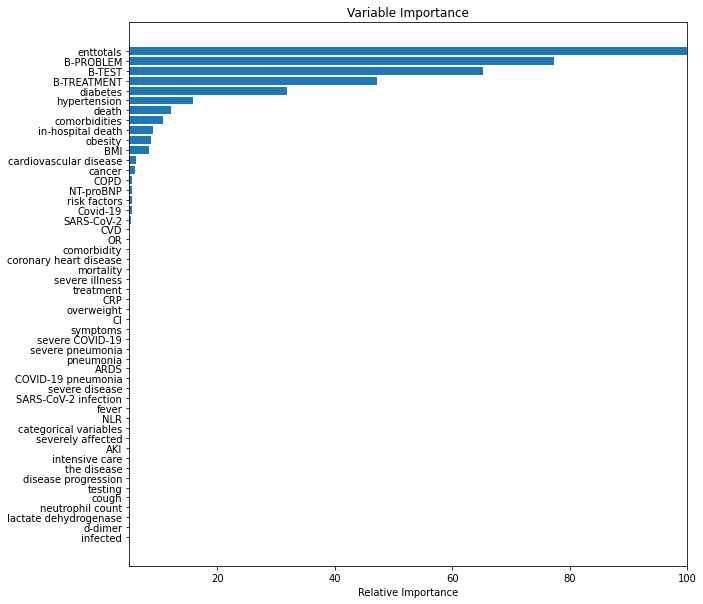

In [524]:
from matplotlib import pyplot as plt



feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-50:]
pos = np.arange(sorted_idx.shape[0]) + .5

fig, ax = plt.subplots(figsize =(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlim(5,100)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()



In [ ]:
from matplotlib import pyplot as plt



feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-50:]
pos = np.arange(sorted_idx.shape[0]) + .5

fig, ax = plt.subplots(figsize =(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()



In [ ]:
## Removed data analysis related features
## Added length of section feature since number of entities in section was such an important feature. This increased score from 83 to...

## Prep for visualizations

In [ ]:
problems=bigdf2[bigdf2['label']=='B-PROBLEM']

In [ ]:
tests=bigdf2[bigdf2['label']=='B-TEST']

In [ ]:
#len(problems[problems['chunks']=='proteinuria'])

In [ ]:
probhist=pd.DataFrame(problems['chunks'].value_counts())
probhist=probhist.rename(columns={'chunks':'counts'})
probhist2=probhist.iloc[0:100]

In [ ]:
testhist=pd.DataFrame(tests['chunks'].value_counts())
testhist=testhist.rename(columns={'chunks':'counts'})
testhist2=testhist.iloc[0:100]

## Look at most frequent "Test" entities

In [ ]:
testhist2.head(40)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize =(24,12))
chart=sns.barplot(testhist2.index,testhist2['counts'])
chart.set_xticklabels(testhist2.index,rotation=90)
plt.title('Test Entities',fontsize=18)
plt.show()

The pretrained model is returning a lot of false positive for Test entities, but you can still see that kidney related tests such as "creatinine" are well represented in the dataset.

## Look at most frequent "Problem" entities

In [ ]:
probhist2.iloc[39:79]

In [ ]:
import seaborn as sns
import seaborn as sns
fig, ax = plt.subplots(figsize =(24,12))
chart=sns.barplot(probhist2.index,probhist2['counts'])
chart.set_xticklabels(probhist2.index,rotation=90)
plt.title('Problem Entities',fontsize=18)
plt.show()

You can see that kidney related problems such as "AKI" are well represented in the dataset.

## Find 'Test' entities near the most frequent kidney related 'Problem' entity

In [ ]:
problems=pd.DataFrame(problems).reset_index(drop=True)
problems['sectionid']=problems.docid+'-'+problems.section

In [ ]:
tests=pd.DataFrame(tests).reset_index(drop=True)
tests['sectionid']=tests.docid+'-'+tests.section

In [ ]:
akis=pd.DataFrame(problems[problems['chunks']=='AKI']).reset_index(drop=True)

In [ ]:
a=list(set(akis['sectionid']))

In [ ]:
akitest=tests[tests['sectionid'].isin(a)]

In [ ]:
akicount=pd.DataFrame(akitest.groupby(['chunks'])['label'].count()).reset_index()

akicount=akicount.sort_values(by='label',ascending=False).reset_index(drop=True)
akicount.columns=['chunk','counts']

In [ ]:
akicount

In [ ]:
import seaborn as sns
import seaborn as sns
fig, ax = plt.subplots(figsize =(24,12))
chart= sns.barplot(akicount['chunk'][0:50],akicount['counts'][0:50])

chart.set_xticklabels(akicount.chunk,rotation=90)
plt.title("Clinical Tests Near 'AKI'",fontsize=20)


plt.show()

Our clinical tests NER is returning a lot of false positives but we still see that creatinine, CRP, and PCR tests  are well represented in the dataset, appearing in the same section as "AKI". This tells me the information is probably not historical and I will have measurements that I can use for predictions as well as terms to use for topic modelling and text classification.

## Find 'Problem' entities near the most frequent kidney related 'Test' entity

In [ ]:
creatins=pd.DataFrame(tests[tests['chunks']=='creatinine']).reset_index(drop=True)
b=list(set(creatins['sectionid']))
creatprob=problems[problems['sectionid'].isin(b)]
creatcount=pd.DataFrame(creatprob.groupby(['chunks'])['label'].count()).reset_index()

creatcount=creatcount.sort_values(by='label',ascending=False).reset_index(drop=True)
creatcount.columns=['chunk','counts']

In [ ]:
creatcount

In [ ]:
creatcounts=creatcount.iloc[0:50]

In [ ]:
import seaborn as sns
import seaborn as sns
fig, ax = plt.subplots(figsize =(24,12))
chart= sns.barplot(creatcounts.chunk,creatcounts['counts'])

chart.set_xticklabels(creatcounts.chunk,rotation=90)
plt.title("Patient Problems Near 'Creatinine' Test",fontsize=20)


plt.show()

AKI, hypertension, diabetes, and acute kidney injury are all well represented in the dataset, appearing in the same section as "creatinine" tests. This tells me the information is probably not historical and I will have measurements that I can use for predictions as well as terms to use for topic modelling and text classification.

## Frequency of 'patient' mentions in documents

In [ ]:
patient=pd.DataFrame(big[(big['token'].str.lower()=='patient')|(big['token'].str.lower()=='patients')]).reset_index(drop=True)

In [ ]:
patients=patient.groupby(['docid'])['token'].count()
patients=patients.reset_index()
patients=patients.rename(columns={'token':'counts'})
len(patients)

In [ ]:
sns.boxplot(patients['counts'])
plt.title('Frequency of Patient Mentions in 1568 Documents',fontsize=14)

## Frequency of 'case report' mentions in documents

In [ ]:
case=pd.DataFrame(big[(big['section'].str.lower()=='case report')|(big['section']=='case study')|(big['chunks'].str.lower()=='case report')|(big['chunks'].str.lower()=='case study')|(big['section'].str.lower()=='case reports')|(big['section']=='case studies')|(big['chunks'].str.lower()=='case reports')|(big['chunks'].str.lower()=='case studies')]).reset_index(drop=True)

In [ ]:
cases=case.groupby(['docid'])['section'].count()
cases=cases.reset_index()
cases=cases.rename(columns={'section':'counts'})
len(cases)

In [ ]:
sns.boxplot(cases['counts'])
plt.title('Frequency of Case Report/Study Mentions in 78 Documents',fontsize=14)

78 documents refer to case reports a median of about 550 times (The average document length is about 30,000 words.) I think I will have enough patient data to attempt some predictions.

In [ ]:
artlist=kag['Study']
pres=[]
doc=[]
for i in os.listdir('document_parses/pdf_json'):
    with open('document_parses/pdf_json/'+i) as json_file:
        data = json.load(json_file)
        if data['metadata']['title'] in list(artlist):
            for c,j in enumerate(data['body_text']):
            
          
                row=[i,data['metadata']['title'],data['body_text'][c]['section'],data['body_text'][c]['text']]
                doc.append(row)

            pres.append(doc)
                    
            

In [ ]:
jsons=[j[0] for i in pres for j in i]
titles=[j[1] for i in pres for j in i]
sections=[j[2].lower() for i in pres for j in i]
text=[j[1].lower()+'.  '+j[2].lower()+'.  '+j[3].lower() for i in pres for j in i]
pres2=pd.DataFrame(None,columns=['jsons','titles','sections','text'])

In [ ]:
pres2['jsons']=jsons
pres2['titles']=titles
pres2['section']=sections
pres2['text']=text

In [ ]:
pres2.head(1)

In [ ]:
case=pd.DataFrame(pres2[(pd.Series(pres2['section']).str.contains('case report'))|(pd.Series(pres2['section']).str.contains('case study'))|(pd.Series(pres2['text']).str.contains('case report'))|(pd.Series(pres2['text']).str.contains('case study'))|(pd.Series(pres2['section']).str.contains('case reports'))|(pd.Series(pres2['section']).str.contains('case studies'))|(pd.Series(pres2['text']).str.contains('case reports'))|(pd.Series(pres2['text']).str.contains('case studies'))]).reset_index(drop=True)

In [ ]:
case.head()

In [ ]:
len(case)

In [ ]:
case['jsons'].nunique()

In [ ]:
case['titles'].value_counts()